###### exteend the training dataset to cover release_8 ,release_4 which they are parallel

## Pre-processing ##
Now that everything is set up, we want to load our data, but first we need to load a couple of useful python packages:


In [8]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras

# load and plot dataset from segments.ai

In [30]:
from segments import SegmentsClient, SegmentsDataset
from segments.utils import export_dataset
from segments.utils import get_semantic_bitmap

# Initialize a SegmentsDataset from the release file
client = SegmentsClient('1ab6d79f821642127c1ab3b3afc69efdd8314566')
dataset_name_8 = 'aydakhorasani/line_8_2'
dataset_name_4 = 'aydakhorasani/inline_4_3'

# Get a list of image URLs

release_8 = client.get_release(dataset_name_8, 'fault_8_2') # Alternatively: release = 'flowers-v1.0.json'
release_4 = client.get_release(dataset_name_4, 'fault_04_2') # Alternatively: release = 'flowers-v1.0.json'
# release_10 = client.get_release(dataset_name_10, 'v0.10.fault.new') # Alternatively: release = 'flowers-v1.0.json'

Initialized successfully.


Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.57it/s]

Initialized dataset with 1 images.


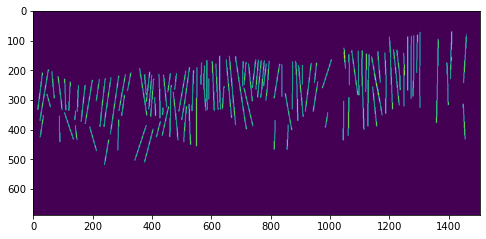

In [34]:
dataset = SegmentsDataset(release_8)
for sample in dataset:
    label = get_semantic_bitmap(sample['segmentation_bitmap'], sample['annotations'])
plt.figure(figsize=(8,8))     
plt.imshow(label)

Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.77it/s]

Initialized dataset with 1 images.


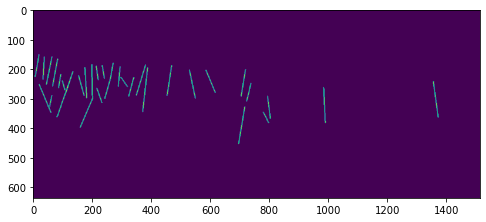

In [33]:
dataset = SegmentsDataset(release_4)
for sample in dataset:
    label = get_semantic_bitmap(sample['segmentation_bitmap'], sample['annotations'])
plt.figure(figsize=(8,8))    
plt.imshow(label)

In [35]:
np.unique(label)

array([0, 2])

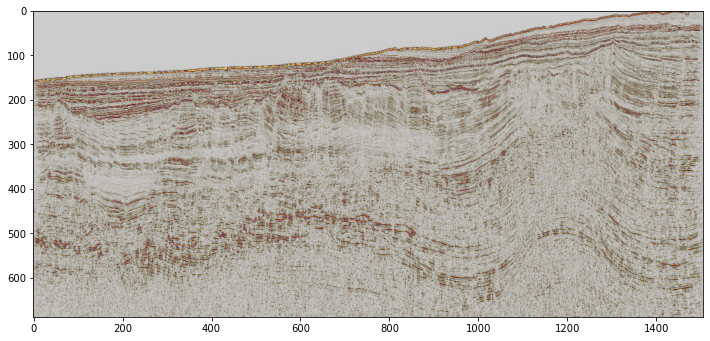

In [38]:
a = sample['image']
plt.figure(figsize=(12,12)) 
plt.imshow(np.array(a))

Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.16it/s]

Initialized dataset with 1 images.


Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.14it/s]

Initialized dataset with 1 images.


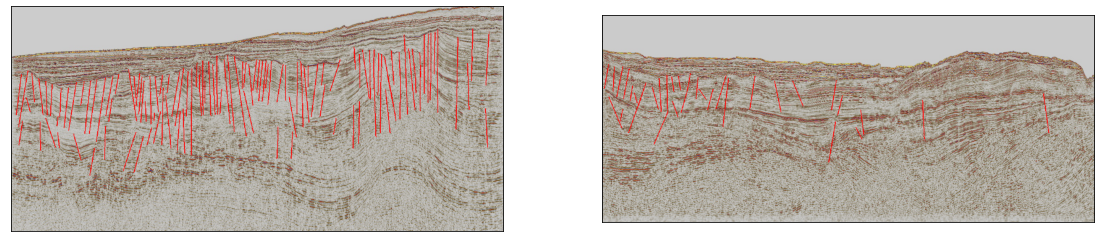

In [40]:
# from google.colab import widgets

def load_data_label(release):
    dataset = SegmentsDataset(release)
    for sample in dataset:
        label = get_semantic_bitmap(sample['segmentation_bitmap'], sample['annotations'])
        data = np.asarray(sample['image']) / 255.
        #converting to grayscale
#         data = 0.2989*data[:,:,0] + 0.5870*data[:,:,1] + 0.1140*data[:,:,2]
#         data = Image.open(data_dir + sample['file_name'])
    label = np.asarray(label)
    return data, label


def plot_overlay(image, label, i):
    (tmax, xmax) = np.shape(label)

    label_rgb = np.zeros((tmax,xmax,4), 'uint8')
    label_rgb[:,:,0] = 255
    label_rgb[:,:,1] = 255 - 255*label
    label_rgb[:,:,2] = 255 - 255*label
    label_rgb[:,:,3] = 255*label   
    
    img = Image.fromarray(label_rgb, mode='RGBA')
    
#     img_gray = 0.2989*image[:,:,0] + 0.5870*image[:,:,1] + 0.1140*image[:,:,2]
    image_rgb = np.zeros((tmax,xmax,4), 'uint8')    
    image_rgb[:,:,0] = 255*image[:,:,0]
    image_rgb[:,:,1] = 255*image[:,:,1]
    image_rgb[:,:,2] = 255*image[:,:,2]
#     image_rgb[:,:,0:3] = 255. * image
    image_rgb[:,:,3] = 255
    
    background = Image.fromarray(image_rgb, mode='RGBA') 
    background.paste(img, (0, 0), img)

#     background = Image.fromarray(image_rgb, mode='RGBA') 
#     print(image.shape)
#     print(label.shape)
#     background.paste(label, (0, 0), label)

    plt.subplot(1,3,i+1).imshow(background)
    plt.xticks([])
    plt.yticks([])


release = [release_8, release_4]
plt.figure(figsize=(30,30))
for i, rel in enumerate(release):
    
    data, label = load_data_label(rel)
    plot_overlay(data, label, i)
    plt.xticks([])
    plt.yticks([])

make training and validation dataset, (patchify, size of patch, ...),
#  window size  is  128,RGB,
# I used release_8,  for  both train and validation

In [41]:
def patchify(data, label, size, number, threshold):

    (t_max, x_max) = label.shape    
    X = np.zeros((number, size, size, 3))
    Y = np.zeros((number, size, size, 1))
        
    n = 0
    while n < number: 
        x = random.randint(size//2, x_max-size//2)
        t = random.randint(size//2, t_max-size//2)
        if np.count_nonzero(label[t-size//2:t+size//2, x-size//2:x+size//2]) > threshold:
            X[n,:,:,:]  = data[t-size//2:t+size//2, x-size//2:x+size//2,:]
            Y[n,:,:,0]  = label[t-size//2:t+size//2, x-size//2:x+size//2]
            n = n + 1
    return X, Y

random.seed(110)

# Parameters
size       = 128
threshold  = 0
num_train  = 10000
num_val    = 2000


# Validation data from inline 300
X_val = np.zeros((num_val,size,size,3))
Y_val = np.zeros((num_val,size,size,1))

seismic, label = load_data_label(release_8)

X_val, Y_val = patchify(seismic[:,753:,:], label[:,753:]//2, size, num_val, threshold)


# Training data from inlines 100, 200, 400, 500
X_train = np.zeros((num_train,size,size,3))
Y_train = np.zeros((num_train,size,size,1))

release_list = [release_8]
n = 0
for release in release_list:
    seismic, label = load_data_label(release)
    
    X_train[n:n+num_train//1,...], Y_train[n:n+num_train//1,...] = patchify(seismic[:,:753,:], label[:,:753]//2, size, num_train//1, threshold) 
    n += num_train//1

Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.13it/s]

Initialized dataset with 1 images.


Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.61it/s]

Initialized dataset with 1 images.


Before training, it's always a good idea to check the training data, so let's do that:

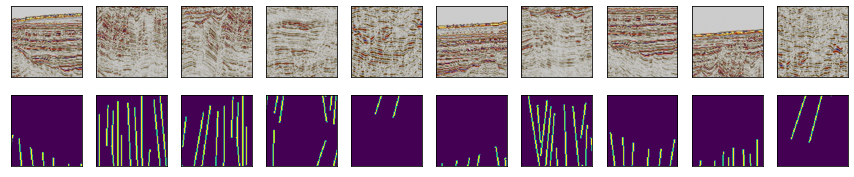

In [42]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))

K = []
for m in range(10):
    k = random.randint(0,4000)
    K.append(k)
    axs[0,m].imshow(X_train[k,:,:,:], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
    axs[0,m].set_xticks([])
    axs[0,m].set_yticks([])

# K = np.stack(K)
for m in range(10):
    axs[1,m].imshow(Y_train[K[m],:,:,0], interpolation='spline16', aspect=1)
    axs[1,m].set_xticks([])
    axs[1,m].set_yticks([])
    k += 1


## Training ##
To train our model, we need to define its architecture. 



In [43]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

  


def UNet():
  f = [8, 16, 32]
  inputs = tf.keras.layers.Input((size, size, 3))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
#   c2, p2 = down_block(p1, f[1]) #64 -> 32
#   c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p1, f[1]) #16->8
  
  bn = bottleneck(p4, f[2])
  
  u1 = up_block(bn, c4, f[1]) #8 -> 16
#   u2 = up_block(u1, c3, f[2]) #16 -> 32
#   u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u1, c1, f[0]) #64 -> 128
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = tf.keras.models.Model(inputs, outputs)
  return model



size = 128
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 128, 128, 8)  224         ['input_2[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 128, 8)  584         ['conv2d_11[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 8)   0           ['conv2d_12[0][0]']        

# Now you can train your convolutional neural net using the data generator:
##I increased epochs rank!(30 times my model was trained)

In [44]:
from keras.callbacks import CSVLogger
csvlogger = CSVLogger('history_2_Nov_new.csv', append=True)
history = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=10,
                    callbacks=[csvlogger])

model.save('checkpoint_tot3_2_Nov_new')

Epoch 1/10
313/313 [==============================] - 211s 671ms/step - loss: 0.2340 - acc: 0.9357 - val_loss: 0.2143 - val_acc: 0.9423
Epoch 2/10
313/313 [==============================] - 218s 697ms/step - loss: 0.1898 - acc: 0.9379 - val_loss: 0.2263 - val_acc: 0.9423
Epoch 3/10
313/313 [==============================] - 209s 667ms/step - loss: 0.1523 - acc: 0.9398 - val_loss: 0.2472 - val_acc: 0.9353
Epoch 4/10
313/313 [==============================] - 219s 701ms/step - loss: 0.1226 - acc: 0.9505 - val_loss: 0.2837 - val_acc: 0.9262
Epoch 5/10
313/313 [==============================] - 215s 688ms/step - loss: 0.1030 - acc: 0.9584 - val_loss: 0.3179 - val_acc: 0.9277
Epoch 6/10
313/313 [==============================] - 212s 676ms/step - loss: 0.0917 - acc: 0.9633 - val_loss: 0.3173 - val_acc: 0.9195
Epoch 7/10
313/313 [==============================] - 196s 625ms/step - loss: 0.0830 - acc: 0.9671 - val_loss: 0.3441 - val_acc: 0.9161
Epoch 8/10
313/313 [============================

INFO:tensorflow:Assets written to: checkpoint_tot3_2_Nov_new\assets


INFO:tensorflow:Assets written to: checkpoint_tot3_2_Nov_new\assets


To visualize our training, you can plot learning curves:

In [46]:
model.load_weights('checkpoint_tot3_2_Nov_new')

In [47]:
import pandas as pd
history = pd.read_csv('history_2_Nov_new.csv')

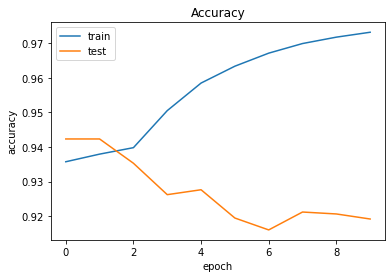

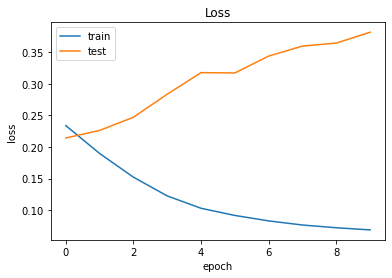

In [48]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.show()

# and a F1 Score:

In [68]:
from keras import backend as K

def F1_score(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [50]:
Y_true.shape

(2000, 128, 128, 1)

In [52]:
np.unique(Y_true)

array([0., 1.])

In [53]:
np.unique(y_pred)

array([0., 1.], dtype=float32)

In [ ]:
#np.unique(y_pred>0.5)

In [69]:
y_pred = model.predict(X_val)
Y_pred = 1. * (y_pred>0.5)
Y_true = Y_val

print(F1_score(Y_true, Y_pred).numpy())

63/63 [==============================] - 7s 112ms/step
0.07586021076879373


In [54]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_val)
Y_true = Y_val    

cm = np.zeros((2,2))

for n in range(Y_true.shape[0]):

  y_true = Y_true[n,:,:,0].round().flatten()
  y_pred = Y_pred[n,:,:,0].round().flatten()

  cm_batch = confusion_matrix(y_true, y_pred)
              

  cm = cm + cm_batch

63/63 [==============================] - 7s 111ms/step


# Consiusion Matrix

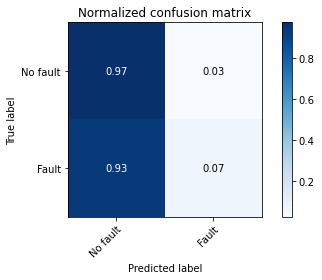

In [56]:
cmap=plt.cm.Blues
normalize = True

title = 'Normalized confusion matrix'


# Only use the labels that appear in the data
classes = ['No fault','Fault']

# Normalize
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


fig, ax = plt.subplots()
im = ax.imshow(cm_norm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm_norm.shape[1]),
       yticks=np.arange(cm_norm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
                ha="center", va='center',
                color="white" if cm_norm[i, j] > thresh else "black")
fig.tight_layout()

## Application##
Now we can apply our model to the entire image to see how well it has learned to recognize salt structures in our seismic image:

In [57]:
def tile(data, wsize, dt, dx):
    
    (t_max, x_max, _) = data.shape    
    
    n_patch = (t_max//dt+1)*(x_max//dx+1)
    data_patch = np.zeros((n_patch,wsize,wsize,3)) 

    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):    
            if t_max - t < wsize and x_max - x < wsize:
                data_patch[n,:,:,:] = data[t_max-wsize:t_max, x_max-wsize:x_max,:]
            elif x_max - x < wsize:
                data_patch[n,:,:,:] = data[t:t+wsize, x_max-wsize:x_max,:]
            elif t_max - t < wsize:
                data_patch[n,:,:,:] = data[t_max-wsize:t_max, x:x+wsize,:]
            else:
                data_patch[n,:,:,:] = data[t:t+wsize,x:x+wsize, :]  
            n = n + 1
    
    return data_patch 




def merge(data_patch, t_max, x_max, wsize, dt, dx):

    data_new = np.zeros((t_max, x_max,3))
    count = np.zeros((t_max, x_max, 1))
    
    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):
            if t_max - t < wsize and x_max - x < wsize:
                data_new[t_max-wsize:t_max, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x_max-wsize:x_max,0] += 1
            elif x_max - x < wsize:
                data_new[t:t+wsize, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t:t+wsize, x_max-wsize:x_max,0] += 1 
            elif t_max - t < wsize:
                data_new[t_max-wsize:t_max, x:x+wsize,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x:x+wsize,0] += 1
            else:
                data_new[t:t+wsize,x:x+wsize,0] += data_patch[n,:,:,0]
                count[t:t+wsize,x:x+wsize,0] += 1 
            n = n + 1

    return data_new/count

def plot_overlay(image, label, i):
    (tmax, xmax) = np.shape(label)

    label_rgb = np.zeros((tmax,xmax,4), 'uint8')
    label_rgb[:,:,0] = 255
    label_rgb[:,:,1] = 255 - 255*label
    label_rgb[:,:,2] = 255 - 255*label
    label_rgb[:,:,3] = 255*label   
    
    img = Image.fromarray(label_rgb, mode='RGBA')
    
    image_rgb = np.zeros((tmax,xmax,4), 'uint8')    
    image_rgb[:,:,0] = 255*image[:,:,0]
    image_rgb[:,:,1] = 255*image[:,:,1]
    image_rgb[:,:,2] = 255*image[:,:,2]
#     image_rgb[:,:,0:3] = 255. * image
    image_rgb[:,:,3] = 255
    
    background = Image.fromarray(image_rgb, mode='RGBA') 
    background.paste(img, (0, 0), img)

#     background = Image.fromarray(image_rgb, mode='RGBA') 
#     print(image.shape)
#     print(label.shape)
#     background.paste(label, (0, 0), label)

    plt.subplot(1,5,i+1).imshow(background)
    plt.xticks([])
    plt.yticks([])



Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.61it/s]

Initialized dataset with 1 images.


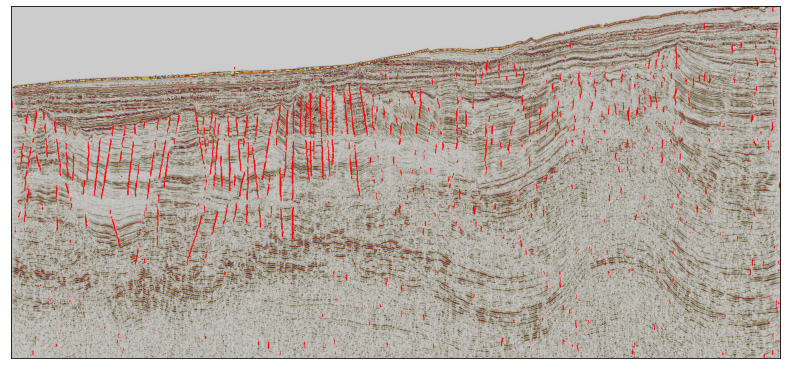

In [67]:
dt = 128
dx = 128

data, label = load_data_label(release_8)
# data = data[:700, :800]
# lable = label[:700, :800]
(t_max, x_max, _) = data.shape

plt.figure(figsize=(80,20))
    
for i in range(1): 
    data_tiles   = tile(data, size, dt, dx)
    result_tiles = 1.*(model.predict_on_batch(data_tiles)>0.6)
    result       = merge(result_tiles, t_max, x_max, size, dt, dx)
    plot_overlay(data, result[:,:,0],i)
    plt.xticks([])
    plt.yticks([])

In [25]:
data.shape

(688, 1505, 3)

Initializing dataset...
Preloading all samples. This may take a while...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.79it/s]

Initialized dataset with 1 images.


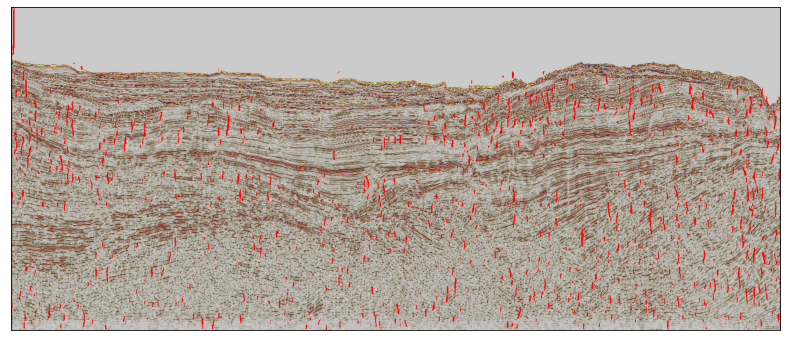

In [72]:
dt = 128
dx = 128
data, label = load_data_label(release_4)
(t_max, x_max, _) = data.shape

plt.figure(figsize=(80,20))
    
for i in range(1): 
    data_tiles   = tile(data[:,:,0:3], size, dt, dx)
    result_tiles = 1.*(model.predict_on_batch(data_tiles)>0.4)
    result       = merge(result_tiles, t_max, x_max, size, dt, dx)
    plot_overlay(data, result[:,:,0], i)
    plt.xticks([])
    plt.yticks([])